## LSTM-VAE multi-modal anomaly detector

An unsupervised model for detecting anomaly whenever a deviation in reconstruction error is found in comparison to normal behavior. LSTM-VAE does multimodal data fusion by combining sensor feature data over time. A learnable threshold is used to decide on anomalous behavior. In the case of MHHD the sensors are Apps, Key Strokes, URLs, (and potentially Voice, Camera, Registry Keys).

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import math
import json
from scipy import signal
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

import tensorflow as tf

import keras
from keras.layers import Input, Dense, Lambda, Layer
from keras.layers import LSTM, RepeatVector
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras import optimizers
from keras.datasets import mnist

from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard
from keras.callbacks import LearningRateScheduler 
from keras.callbacks import EarlyStopping

from keras.utils import plot_model

Using TensorFlow backend.


In [2]:
#generate data
num_sensors = 10
noise_scale = 10
signal_len = 5000
t = np.linspace(0, signal_len, signal_len)

train_data_frame = pd.DataFrame()
test_data_frame = pd.DataFrame()

for idx in range(num_sensors):
    
    #sample sensor parameters
    signal_type = np.random.randint(low=0, high=3, size=1)[0]
    signal_amplitude = np.random.randint(low=1, high=100, size=1)[0]
    signal_frequency = np.random.randint(low=5, high=20, size=1)[0]
    signal_phase = np.random.randint(low=1, high=10, size=1)[0]
    signal_offset = np.random.randint(low=-20, high=20, size=1)[0]
    signal_noise = np.random.normal(1, noise_scale, len(t))[0]
    
    #create sensor signal
    if (signal_type == 0):
        sensor = signal_amplitude*signal.square(2*np.pi*signal_frequency*t + signal_phase) + signal_offset + signal_noise
    elif (signal_type == 1):
        sensor = signal_amplitude*np.sin(2*np.pi*signal_frequency*t + signal_phase) + signal_offset + signal_noise
    else:
        sensor = signal_amplitude*signal.sawtooth(2*np.pi*signal_frequency*t + signal_phase) + signal_offset + signal_noise
    #end if
    
    #sample anomaly parameters
    anomaly_type = np.random.randint(low=0, high=2, size=1)[0]
    anomaly_idx = np.random.randint(low=0.2*len(t), high=0.8*len(t), size=1)[0]
    anomaly_magnitude = np.random.randint(low=0.2*signal_amplitude, high=signal_amplitude, size=1)[0]
    anomaly_frequency = np.random.randint(low=signal_frequency, high=2*signal_frequency, size=1)[0]
    anomaly_phase = np.random.randint(low=signal_phase, high=2*signal_phase, size=1)[0]
    anomaly_offset = signal_offset + np.random.randint(low=0, high=20, size=1)[0]
    anomaly_noise = signal_noise + np.random.normal(1, noise_scale, len(t))[0]
    anomaly_window_size = np.random.randint(low=100, high=200, size=1)[0]
    anomaly_window_std = np.random.randint(low=100, high=200, size=1)[0]
    
    #create anomaly signal
    sensor_anomaly = np.copy(sensor)
    if (anomaly_type == 0):
        anomaly = anomaly_magnitude * signal.gaussian(anomaly_window_size, std=anomaly_window_std)
        sensor_anomaly[anomaly_idx:anomaly_idx+anomaly_window_size] += anomaly
    elif (anomaly_type == 1 and signal_type == 0):
        sensor_anomaly[anomaly_idx:-1] = anomaly_magnitude*signal.square(2*np.pi*anomaly_frequency*t[anomaly_idx:-1] + anomaly_phase) + anomaly_offset + anomaly_noise
    elif (anomaly_type == 1 and signal_type == 1):
        sensor_anomaly[anomaly_idx:-1] = anomaly_magnitude*np.sin(2*np.pi*anomaly_frequency*t[anomaly_idx:-1] + anomaly_phase) + anomaly_offset + anomaly_noise
    elif (anomaly_type == 1 and signal_type == 2):
        sensor_anomaly[anomaly_idx:-1] = anomaly_magnitude*signal.sawtooth(2*np.pi*anomaly_frequency*t[anomaly_idx:-1] + anomaly_phase) + anomaly_offset + anomaly_noise
    #end if

    col_name = 'sensor' + str(idx)
    train_data_frame[col_name] = sensor
    test_data_frame[col_name] = sensor_anomaly
#end for

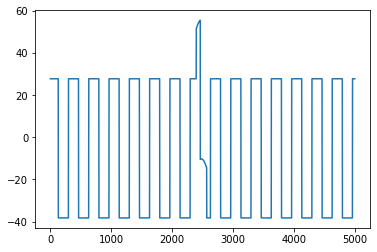

In [3]:
plt.plot(test_data_frame['sensor0'].values)

In [4]:
#pre-process (scale) the data
standard_scaler_dict = {}
train_data = np.zeros((len(t), num_sensors))
test_data = np.zeros((len(t), num_sensors))

for idx in range(num_sensors):

    key = 'data_scaler_' + str(idx)
    col_name = 'sensor' + str(idx)
    
    data_scaler = StandardScaler()
    data_scaler.fit(train_data_frame[col_name].values.reshape(-1,1))

    train_data_scaled = data_scaler.transform(train_data_frame[col_name].values.reshape(-1,1))
    test_data_scaled = data_scaler.transform(test_data_frame[col_name].values.reshape(-1,1))
    
    standard_scaler_dict[key] = data_scaler
    train_data[:,idx] = train_data_scaled.flatten()
    test_data[:,idx] = test_data_scaled.flatten()

#end for

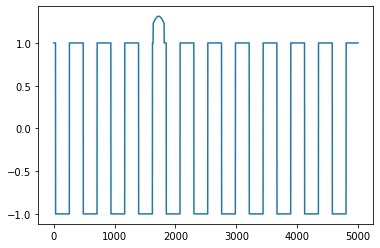

In [5]:
plt.plot(test_data[:,-1])

In [6]:
DATA_PATH = './data/'

def step_decay(epoch):
    lr_init = 0.001
    drop = 0.5
    epochs_drop = 16.0
    lr_new = lr_init * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr_new

class LR_hist(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(step_decay(len(self.losses)))

In [7]:
def create_dataset(dataset, look_back=64, step=1):
    dataX, dataY = [], []
    for i in range(0, len(dataset)-look_back-1, step):
        dataX.append(dataset[i:(i+look_back),:])
        dataY.append(dataset[i+look_back,:])

    return np.array(dataX), np.array(dataY)

In [8]:
X_data, y_data = create_dataset(train_data, look_back=64) #look_back = window_size
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.1, random_state=42)
X_test, y_test = create_dataset(test_data, look_back=64)  #look_back = window_size

In [11]:
#training params
batch_size = 256
num_epochs = 64

#model params
timesteps = X_train.shape[1]
input_dim = X_train.shape[-1]
intermediate_dim = 16 #256
latent_dim = 2
epsilon_std = 1.0

In [12]:
#sampling layer
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.0, stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon

In [13]:
#likelihood layer
def likelihood(args):
    x, x_decoded_mean, x_decoded_scale = args
    dist = tf.contrib.distributions.MultivariateNormalDiag(x_decoded_mean, x_decoded_scale)
    likelihood = dist.log_prob(x)
    #Q: what dimension is likelihood? (x,x,3)? is 3-dimensional Gaussian evaluates to a scalar probability but what do we want?
    #Q: what is the loss minimizing? do we want a multi-output model
    #Q: return_sequences=False in h=LSTM(intermediate_dim)(x), i.e. one model for all dimensions
    #Q: Is it still MultivariateNormalDiag? If univariate, are there enough degrees of freedom to learn the pattern? e.g. one Gaussian per sensor    
    #Q: We want anomaly and on which sensor it occured as the output
    return likelihood

In [14]:
#likelihood layer
def likelihood_multivariate(args):
    x, x_decoded_mean, x_decoded_scale = args
    
    num_sensors = x.shape[-1]
    
    likelihood_list = []
    for idx in range(num_sensors):
        
        dist = tf.contrib.distributions.Normal(loc=x_decoded_mean[:,:,idx], scale=x_decoded_scale[:,:,idx])
        likelihood = dist.log_prob(x[:,:,idx])
        likelihood_list.append(likelihood)

    #end for

    return tf.keras.backend.stack(likelihood_list,axis=-1)

In [15]:
#VAE architecture

#encoder
x = Input(shape=(timesteps, input_dim,), name="input_sequence")
h = LSTM(intermediate_dim)(x)

z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim, activation='softplus')(h)

#sampling
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

#decoder
decoder_h = LSTM(intermediate_dim, return_sequences=True)
decoder_loc = LSTM(input_dim, return_sequences=True)
decoder_scale = LSTM(input_dim, activation='softplus', return_sequences=True)

h_decoded = RepeatVector(timesteps)(z)
h_decoded = decoder_h(h_decoded)

x_decoded_mean = decoder_loc(h_decoded)
x_decoded_scale = decoder_scale(h_decoded)

like = Lambda(likelihood_multivariate, output_shape=(timesteps, input_dim,), name="likelihood")([x, x_decoded_mean, x_decoded_scale])





The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [16]:
#custom loss layer
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)
    
    def vae_loss(self, x, z_mean, z_log_sigma, likelihood):        
        kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma))
        loss = -K.mean(likelihood - kl_loss)
        return loss

    def call(self, inputs):
        x = inputs[0]
        z_mean = inputs[1]
        z_log_sigma = inputs[2]
        likelihood = inputs[3]
        loss = self.vae_loss(x, z_mean, z_log_sigma, likelihood)
        self.add_loss(loss, inputs=inputs)
        return x

In [17]:
y = CustomVariationalLayer()([x, z_mean, z_log_sigma, like])
vae_like = Model(x, like)
vae = Model(x, y)

In [18]:
adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
vae.compile(loss=None, optimizer=adam, metrics=['accuracy'])
vae.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_sequence (InputLayer)     (None, 64, 10)       0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 16)           1728        input_sequence[0][0]             
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2)            34          lstm_1[0][0]                     
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            34          lstm_1[0][0]                     
__________________________________________________________________________________________________
lambda_1 

In [19]:
#define callbacks
file_name = DATA_PATH + 'lstm-vae-anomaly-detector-multisensor.hdf5'
checkpoint = ModelCheckpoint(file_name, monitor='loss', verbose=1, save_best_only=True, mode='min')
tensor_board = TensorBoard(log_dir='./logs', write_graph=True)
hist_lr = LR_hist()
reduce_lr = LearningRateScheduler(step_decay) 
early_stopping = EarlyStopping(monitor='loss', min_delta=0.01, patience=64, verbose=1)
callbacks_list = [checkpoint, hist_lr, reduce_lr, early_stopping]

In [20]:
print("training vae model...")
hist = vae.fit(x=X_train, y=None, shuffle=True, epochs=num_epochs, batch_size=batch_size, callbacks=callbacks_list, validation_data=(X_val, None), verbose=2)

training vae model...
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 4441 samples, validate on 494 samples
Epoch 1/64





 - 8s - loss: 1.9549 - val_loss: 1.7783

Epoch 00001: loss improved from inf to 1.95485, saving model to ./data/lstm-vae-anomaly-detector-multisensor.hdf5
Epoch 2/64
 - 3s - loss: 1.7012 - val_loss: 1.6327

Epoch 00002: loss improved from 1.95485 to 1.70117, saving model to ./data/lstm-vae-anomaly-detector-multisensor.hdf5
Epoch 3/64
 - 3s - loss: 1.6032 - val_loss: 1.5788

Epoch 00003: loss improved from 1.70117 to 1.60317, saving model to ./data/lstm-vae-anomaly-detector-multisensor.hdf5
Epoch 4/64
 - 3s - loss: 1.5624 - val_loss: 1.5466

Epoch 00004: loss improved from 1.60317 to 1.56242, saving model to ./data/lstm-vae-anomaly-detector-multisensor.hdf5
Epoch 5/64
 - 3s - loss: 1.5324 - val_loss: 1.5190

Epoch 00005: loss improved from 1.56242 to 1.53240, saving model to ./data/lstm-vae-anomaly-detector-

 - 4s - loss: 1.4378 - val_loss: 1.4386

Epoch 00038: loss did not improve from 1.43776
Epoch 39/64
 - 4s - loss: 1.4376 - val_loss: 1.4381

Epoch 00039: loss improved from 1.43776 to 1.43760, saving model to ./data/lstm-vae-anomaly-detector-multisensor.hdf5
Epoch 40/64
 - 4s - loss: 1.4374 - val_loss: 1.4381

Epoch 00040: loss improved from 1.43760 to 1.43740, saving model to ./data/lstm-vae-anomaly-detector-multisensor.hdf5
Epoch 41/64
 - 4s - loss: 1.4372 - val_loss: 1.4375

Epoch 00041: loss improved from 1.43740 to 1.43725, saving model to ./data/lstm-vae-anomaly-detector-multisensor.hdf5
Epoch 42/64
 - 4s - loss: 1.4371 - val_loss: 1.4380

Epoch 00042: loss improved from 1.43725 to 1.43710, saving model to ./data/lstm-vae-anomaly-detector-multisensor.hdf5
Epoch 43/64
 - 4s - loss: 1.4369 - val_loss: 1.4375

Epoch 00043: loss improved from 1.43710 to 1.43692, saving model to ./data/lstm-vae-anomaly-detector-multisensor.hdf5
Epoch 44/64
 - 4s - loss: 1.4369 - val_loss: 1.4373

Epoc

In [ ]:
#vae.save(DATA_PATH + 'lstm-vae-anomaly-detector-final-model.h5', overwrite=True)
#vae.save_weights(DATA_PATH + 'lstm-vae-anomaly-detector-weights.h5', overwrite=True)

In [ ]:
#load saved model
#vae = load_model(DATA_PATH + 'final_model.h5')

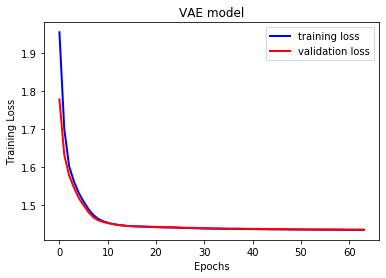

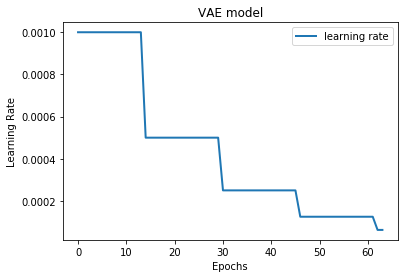

In [21]:
#generate plots

plt.figure()
plt.plot(hist.history['loss'], lw=2.0, c='b', label='training loss')
plt.plot(hist.history['val_loss'], lw=2.0, c='r', label='validation loss')
plt.title('VAE model')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.savefig('./figures/lstm_vae_training_loss.png')


plt.figure()
plt.plot(hist_lr.lr, lw=2.0, label='learning rate')
plt.title('VAE model')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.legend()
plt.savefig('./figures/lstm_vae_learning_rate.png')

In [22]:
pred_test = vae_like.predict(X_test)

In [23]:
X_test.shape

(4935, 64, 10)

In [24]:
pred_test.shape

(4935, 64, 10)

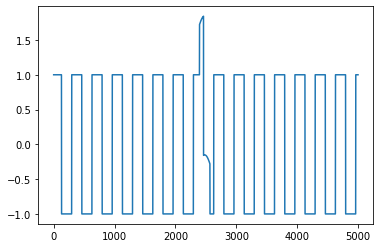

In [29]:
plt.plot(test_data[:,0])

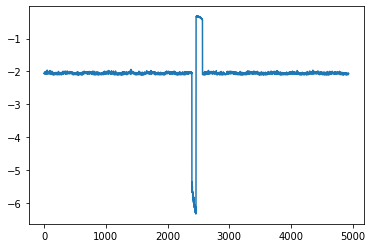

In [30]:
plt.plot(pred_test[:,0,0])

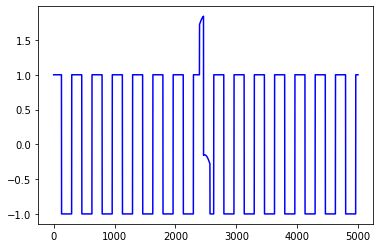

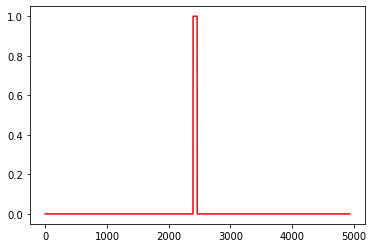

In [34]:
is_anomaly = pred_test[:,0,0] < -4
plt.figure()
plt.plot(test_data[:,0], color='b')
plt.figure()
plt.plot(is_anomaly, color='r')

## Keras to TensorFlow .pb file

In [35]:
#https://stackoverflow.com/questions/45466020/how-to-export-keras-h5-to-tensorflow-pb
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = tf.graph_util.convert_variables_to_constants(
            session, input_graph_def, output_names, freeze_var_names)
        return frozen_graph

In [36]:
from keras import backend as K
frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in vae_like.outputs])

Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 69 variables.
INFO:tensorflow:Converted 69 variables to const ops.


In [37]:
tf.train.write_graph(frozen_graph, "./data", "lstm-vae-anomaly-detector-multisensor.pb", as_text=False)

'./data\\lstm-vae-anomaly-detector-multisensor.pb'

## Load the model and use it in TensorFlow

In [38]:
tf.reset_default_graph()
output_tf_model = 'lstm-vae-anomaly-detector-multisensor.pb'
graph = tf.Graph()
with tf.gfile.GFile('./data/' + output_tf_model, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

In [39]:
with graph.as_default():
    # Define input tensor
    input_tensor = tf.placeholder(np.float32, shape = [None, timesteps, input_dim])
    tf.import_graph_def(graph_def, {'input_sequence': input_tensor})
graph.finalize()

In [42]:
node_names = set([ n.name for n in graph_def.node if 'likelihood/stack' in n.name])
print(node_names)

{'likelihood/stack'}


In [41]:
vae_like.layers[-1].output

<tf.Tensor 'likelihood/stack:0' shape=(?, 64, 10) dtype=float32>

In [43]:
sess = tf.Session(graph=graph)
output_tensor = graph.get_tensor_by_name("import/likelihood/stack:0")
pred_loaded_model = sess.run(output_tensor, feed_dict={input_tensor: X_test})

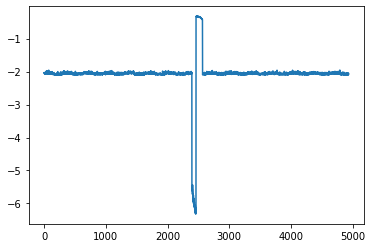

In [47]:
plt.plot(pred_loaded_model[:,0,0])

In [48]:
num_data = X_test.shape[0]
output_rule = []
for idx in range(num_data):
    pred_loaded_model = sess.run(output_tensor, feed_dict={input_tensor: np.expand_dims(X_test[idx,:], axis=0)})
    output_rule.append(np.mean(pred_loaded_model))

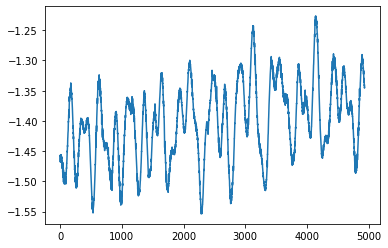

In [49]:
plt.figure()
plt.plot(output_rule)

## References

[1] Park et al., "A Multimodal Anomaly Detector for Robot-Assisted Feeding Using an LSTM-Based Variational Autoencoder", arXiv 2018: https://arxiv.org/pdf/1711.00614.pdf  
[2] Zhang et al, "Time Series Anomaly Detection with Variational Autoencoders": https://arxiv.org/pdf/1907.01702.pdf  
[3] An et al, "Variational Autoencoder based Anomaly Detection using Reconstruction Probability": http://dm.snu.ac.kr/static/docs/TR/SNUDM-TR-2015-03.pdf  |